# **2. Елементи синтаксису**
Сірікова Ольга МІ-41

# Додаємо необхідні бібліотеки


In [3]:
import nltk
import random
import numpy as np
from nltk.corpus import brown
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
tagged_sentences = list(brown.tagged_sents(tagset='universal'))
random.seed(42)
random.shuffle(tagged_sentences)

# Розділяємо дані

80% на тренування і 20% для тестування

In [6]:
split = int(0.8 * len(tagged_sentences))
train_sentences = tagged_sentences[:split]
test_sentences = tagged_sentences[split:]

# Виділяємо слова і теги з речень у списки


In [7]:
def get_words_and_tags(sentences):
    sentences_words = []
    sentences_tags = []
    for sentence in sentences:
        words = [word.lower() for word, tag in sentence]
        tags = [tag for word, tag in sentence]
        sentences_words.append(words)
        sentences_tags.append(tags)
    return sentences_words, sentences_tags

train_words, train_tags = get_words_and_tags(train_sentences)
test_words, test_tags = get_words_and_tags(test_sentences)

In [8]:

words = set([w for s in train_words for w in s])
tags = set([t for s in train_tags for t in s])

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx['PAD'] = 0
word2idx['UNK'] = 1

tag2idx = {t: i for i, t in enumerate(tags)}
tag2idx['PAD'] = len(tag2idx)

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: t for t, i in tag2idx.items()}

n_words = len(word2idx)
n_tags = len(tag2idx)

In [11]:
def generate_context_windows(sentences_words, sentences_tags, word2idx, tag2idx, window_size=1):
    X = []
    y = []
    for words, tags in zip(sentences_words, sentences_tags):
        words_idx = [word2idx.get(word.lower(), word2idx['UNK']) for word in words]
        tags_idx = [tag2idx[tag] for tag in tags]
        padded_words = [word2idx['PAD']] * window_size + words_idx + [word2idx['PAD']] * window_size
        for i in range(window_size, len(padded_words) - window_size):
            context = padded_words[i - window_size:i + window_size + 1]
            X.append(context)
            y.append(tags_idx[i - window_size])
    return np.array(X), np.array(y)

In [12]:
def encode_sentences(sentences, word2idx):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentence = []
        for word in sentence:
            encoded_sentence.append(word2idx.get(word, word2idx['UNK']))
        encoded_sentences.append(encoded_sentence)
    return encoded_sentences

def encode_tags(sentences_tags, tag2idx):
    encoded_tags = []
    for tags in sentences_tags:
        encoded_tag = [tag2idx[tag] for tag in tags]
        encoded_tags.append(encoded_tag)
    return encoded_tags

In [10]:

# Generate context windows for training and testing data
X_train, y_train = generate_context_windows(train_words, train_tags, word2idx, tag2idx, window_size=1)
X_test, y_test = generate_context_windows(test_words, test_tags, word2idx, tag2idx, window_size=1)

# One-hot encode the tags
y_train_cat = to_categorical(y_train, num_classes=n_tags)
y_test_cat = to_categorical(y_test, num_classes=n_tags)

# Adjust the model to accept context windows
inputs = Input(shape=(3,))
embedding = Embedding(input_dim=n_words, output_dim=64)(inputs)
flatten = Flatten()(embedding)
dense = Dense(64, activation='relu')(flatten)
output = Dense(n_tags, activation='softmax')(dense)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 3, 64)               │       2,889,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,903,117 (11.07 MB)

 Trainable params: 2,903,117 (11.07 MB)

 Non-trainable params: 0 (0.00 B)

# Тренуємо модель


In [ ]:

model.fit(
    X_train,
    y_train_cat,
    batch_size=128,
    epochs=5,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
6533/6533 ━━━━━━━━━━━━━━━━━━━━ 207s 32ms/step - accuracy: 0.9066 - loss: 0.3467 - val_accuracy: 0.9734 - val_loss: 0.0802
Epoch 2/5
6533/6533 ━━━━━━━━━━━━━━━━━━━━ 256s 31ms/step - accuracy: 0.9860 - loss: 0.0434 - val_accuracy: 0.9760 - val_loss: 0.0732
Epoch 3/5
6533/6533 ━━━━━━━━━━━━━━━━━━━━ 194s 29ms/step - accuracy: 0.9905 - loss: 0.0284 - val_accuracy: 0.9766 - val_loss: 0.0736
Epoch 4/5
6533/6533 ━━━━━━━━━━━━━━━━━━━━ 204s 30ms/step - accuracy: 0.9926 - loss: 0.0222 - val_accuracy: 0.9759 - val_loss: 0.0775
Epoch 5/5
4662/6533 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.9937 - loss: 0.0182

# Перевіряємо модель на тестових даних

In [17]:
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print("Test accuracy: {:.2f}%".format(100 * accuracy))

7256/7256 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9761 - loss: 0.0799
Test accuracy: 97.61%


# Пояснення до результатів


| Tag   | Description                  | Examples                      |
|-------|------------------------------|-------------------------------|
| **ADJ**   | Adjective                    | *big*, *old*, *blue*            |
| **ADV**   | Adverb                       | *quickly*, *very*, *well*       |
| **NOUN**  | Noun                         | *dog*, *city*, *car*            |
| **PRON**  | Pronoun                      | *I*, *you*, *he*, *she*         |
| **VERB**  | Verb                         | *run*, *eat*, *be*              |
| **.**     | Other                        |             |


# Речення користувача і результат


In [15]:

# User input and prediction
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

import builtins
input = builtins.input

user_input = input("\nEnter a sentence to analyze: ")
sentence = tokenizer.tokenize(user_input)
encoded_sentence = [word2idx.get(word.lower(), word2idx['UNK']) for word in sentence]
padded_sentence = [word2idx['PAD']] + encoded_sentence + [word2idx['PAD']]

X_user = []
for i in range(1, len(padded_sentence) - 1):
    context = padded_sentence[i - 1:i + 2]
    X_user.append(context)

X_user = np.array(X_user)

predictions = model.predict(X_user)
predicted_tags_indices = np.argmax(predictions, axis=1)
predicted_tags = [idx2tag[idx] for idx in predicted_tags_indices]

print("\nPredicted tags:")
for word, tag in zip(sentence, predicted_tags):
    print(f"{word}\t{tag}")



Enter a sentence to analyze: today is a really nice day
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Predicted tags:
today	NOUN
is	VERB
a	DET
really	ADV
nice	ADJ
day	NOUN


7256/7256 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


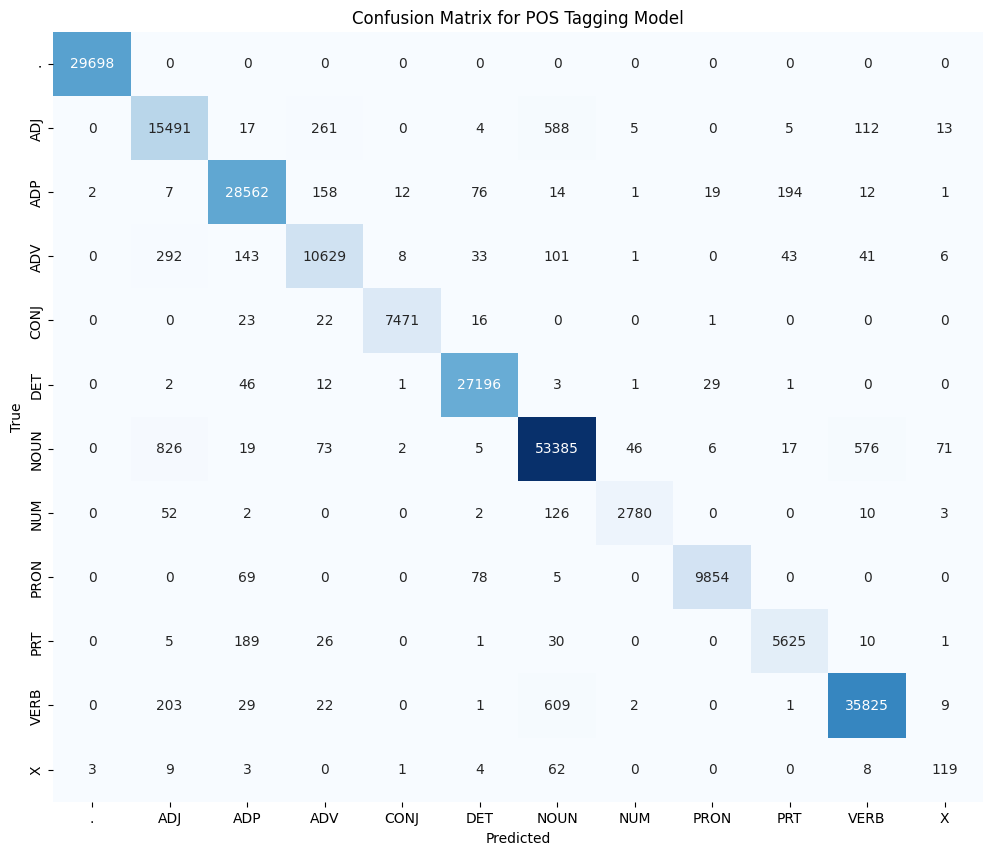

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)

predicted_tags = [idx2tag[idx] for idx in y_pred_indices]
true_tags = [idx2tag[idx] for idx in y_test]

mask = np.array(true_tags) != 'PAD'
predicted_tags_filtered = np.array(predicted_tags)[mask]
true_tags_filtered = np.array(true_tags)[mask]

unique_tags = sorted(set(true_tags_filtered))
tag_index = {tag: i for i, tag in enumerate(unique_tags)}

y_true_indices = [tag_index[tag] for tag in true_tags_filtered]
y_pred_indices_filtered = [tag_index[tag] for tag in predicted_tags_filtered]

cm = confusion_matrix(y_true_indices, y_pred_indices_filtered)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_tags, yticklabels=unique_tags,
            cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for POS Tagging Model')
plt.show()